### [CAM](https://github.com/gcucurull/CAM-Python)과 Grad CAM (by @haven-jeon)






####  설명 

- CAM(Class Activation Map)은 Global Max Pooling 레이어로 만들어진 클래스별 가중치를 기반으로 피처맵의 활성화 정도를 가중하여 클래스를 판별할시 모형이 어떠한 부분에 강점을 두었는지 판단하는 기법 
  - 참고 : http://jsideas.net/python/2018/01/04/class_activation_map.html
- Grad CAM은 CAM과는 다르게 Gradient를 활용하여 가중치를 구하는 차이가 있으며, Global Max Pooling을 가정하지 않는 특징이 있다.
  - 참고 : http://freesearch.pe.kr/archives/4685 




In [1]:
import os
#os.environ['MXNET_ENGINE_TYPE'] = 'NaiveEngine'
#os.environ['MXNET_CUDNN_AUTOTUNE_DEFAULT'] = '1'

import pandas as pd
import numpy as np
from sklearn.utils import shuffle
import mxnet as mx
from mxnet import gluon
from mxnet.gluon import nn
from mxnet.image import color_normalize
import mxnet.autograd as autograd
from mxnet.gluon.model_zoo import vision as models
from tqdm import tqdm

In [2]:
#더미 파일 리스트를 구축한다. , im2rec.py는 https://github.com/apache/incubator-mxnet/blob/master/tools/im2rec.py 
%run im2rec.py --list list catsdogs_full train

In [3]:
#아래 보는것과 같이 텝으로 구분되어서 파일 인덱스, 레이블(클래스), 사진파일명 정보가 구성된다. 
!head catsdogs_full.lst

3197	0.000000	cat.1625.jpg
15084	0.000000	dog.12322.jpg
1479	0.000000	cat.11328.jpg
5262	0.000000	cat.3484.jpg
20714	0.000000	dog.6140.jpg
9960	0.000000	cat.7712.jpg
945	0.000000	cat.10848.jpg
15585	0.000000	dog.1524.jpg
12376	0.000000	cat.9888.jpg
4367	0.000000	cat.2679.jpg


In [6]:
#pandas 테이블로 파일을 읽어들여 레이블을 마킹하고 랜덤 셔플한 뒤 학습과 테스트셋으로 만든다. 
catdoglist = pd.read_csv('catsdogs_full.lst',sep='\t', names=['idx', 'class', 'fn'])

catdoglist['class'] = [1  if i else 0 for i in catdoglist['fn'].str.contains('dog')]

catdoglist = shuffle(catdoglist)

train = catdoglist.iloc[:6500, ]

train.shape

test = catdoglist.iloc[6500:, ]

train.to_csv('catsdogs_train.lst',doublequote=False,sep='\t', header=False, index=False)
test.to_csv('catsdogs_test.lst',doublequote=False,sep='\t', header=False, index=False)

In [165]:
#실제 Image RecordIO dataset을 만든다. 
!python im2rec.py --num-thread 10 catsdogs_t train

/home/gogamza/python_3.6/lib/python3.6/distutils/__init__.py:4: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  import imp
Creating .rec file from /home/gogamza/work/gluons/catsdogs_train.lst in /home/gogamza/work/gluons
time: 0.03124403953552246  count: 0
time: 1.179645299911499  count: 1000
time: 0.976043701171875  count: 2000
time: 1.1002657413482666  count: 3000
time: 1.051544189453125  count: 4000
time: 1.0289239883422852  count: 5000
time: 0.5287754535675049  count: 6000
Creating .rec file from /home/gogamza/work/gluons/catsdogs_test.lst in /home/gogamza/work/gluons
time: 0.18526077270507812  count: 0
time: 0.9183506965637207  count: 1000
time: 0.8911347389221191  count: 2000
time: 1.0432755947113037  count: 3000
time: 0.8570001125335693  count: 4000
time: 1.0042638778686523  count: 5000
time: 0.9739773273468018  count: 6000
time: 0.8833253383636475  count: 7000
time: 0.9417126178741455  count: 8000
ti

#### 모형 생성 

In [2]:
class cats_and_dogs(gluon.HybridBlock):
    def __init__(self, num_class, num_hidden , **kwargs):
        super(cats_and_dogs, self).__init__(**kwargs)
        
        with self.name_scope():
            #model zoo에서 vgg16 모형을 가져온다. 
            #이렇게 vgg를 클래스 내부에서 로딩하면 인스턴스마다 context, prefix 가 통일되게 생성되어 모형 저장/로딩시 용이한 측면이 있다.  
            vgg_net =  models.vgg16(pretrained=True, root=".models").features
            self.features = nn.HybridSequential()
            for i in vgg_net[:31]:
                self.features.add(i)
            self.conv2d = nn.Conv2D(1024, kernel_size=(3,3), activation ='relu')
            self.glob_avg_pool = nn.GlobalAvgPool2D()
            self.dense = nn.Dense(units=num_class)        
    
    def hybrid_forward(self, F, inputs, grad=False):
        o_vgg = self.features(inputs)
        conv2d = self.conv2d(o_vgg)
        gap = self.glob_avg_pool(conv2d)
        gap_re = F.reshape(gap, (-1, 1024))
        pred = self.dense(gap_re)
        if grad:
            return pred, o_vgg
        else:
            return pred
    
    def get_conv(self, F, inputs):
        o_vgg = self.features(inputs)
        conv2d = self.conv2d(o_vgg)
        return conv2d
 

In [4]:
model = cats_and_dogs(num_class=2, num_hidden = 500)

test_d = mx.nd.random.normal(0,1, (1,3, 224, 224), ctx=mx.cpu(0))
model.collect_params().initialize(mx.init.Xavier(), ctx=mx.cpu(0))
model(test_d)

In [41]:
### Symbolic 텐서로 컴파일한다. 
#확실히 GPU메모리 사용량은 줄어드나, 학습 속도가 2배 넘게 빨리지지는 않는거 같다. 
model.hybridize()

In [5]:
print(model)

cats_and_dogs(
  (features): HybridSequential(
    (0): Conv2D(3 -> 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): Activation(relu)
    (2): Conv2D(64 -> 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): Activation(relu)
    (4): MaxPool2D(size=(2, 2), stride=(2, 2), padding=(0, 0), ceil_mode=False)
    (5): Conv2D(64 -> 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): Activation(relu)
    (7): Conv2D(128 -> 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): Activation(relu)
    (9): MaxPool2D(size=(2, 2), stride=(2, 2), padding=(0, 0), ceil_mode=False)
    (10): Conv2D(128 -> 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): Activation(relu)
    (12): Conv2D(256 -> 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): Activation(relu)
    (14): Conv2D(256 -> 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): Activation(relu)
    (16): MaxPool2D(size=(2, 2), stride=(2, 2), padding=(0

#### 학습

In [43]:
#생성한 rec 파일로 이터레이터를 생성한다. 
#Tensorflow와 케라스에서와는 다르게 채널이 먼저 나온다.
#이미지 학습을 하는데 ImageRecordIter는 거의 필수라고 생각하는데, 이는 다양한 data augmentation의 옵션을 제공하기 때문이다.
batch_size = 100  # 멀티 GPU인 관계로 더 많은 배치를 할당해본다. 
valid_batch_size = 60 #validation은 적어도 큰 문제가 없다. 
train_iter = mx.io.ImageRecordIter(path_imgrec='catsdogs_train.rec',
                                   min_img_size=256,
                                   data_shape=(3, 224, 224),
                                   rand_crop=True,
                                   shuffle=True,
                                   batch_size=batch_size,
                                   max_random_scale=1.5,
                                   min_random_scale=0.75,
                                   rand_mirror=True)
val_iter = mx.io.ImageRecordIter(path_imgrec="catsdogs_test.rec",
                                 min_img_size=256,
                                 data_shape=(3, 224, 224),
                                 batch_size=valid_batch_size)

In [44]:


def evaluate(net, data_iter, ctx):
    data_iter.reset()
    acc = mx.metric.Accuracy()
    for batch in data_iter:
        mx.nd.waitall()
        #reference 
        #https://mxnet.incubator.apache.org/api/python/gluon/model_zoo.html
        data = color_normalize(batch.data[0]/255,
                               mean=mx.nd.array([0.485, 0.456, 0.406]).reshape((1,3,1,1)),
                               std=mx.nd.array([0.229, 0.224, 0.225]).reshape((1,3,1,1)))
        data = gluon.utils.split_and_load(data, ctx)
        label = gluon.utils.split_and_load(batch.label[0], ctx)

        with autograd.predict_mode():
            for X, Y in zip(data, label):
                output = net(X)
                predictions = mx.nd.argmax(output, axis=1)
                acc.update(preds=predictions, labels=Y)
                mx.ndarray.waitall()
    return acc.get()[1]


In [45]:
import mxnet.autograd as autograd
from mxnet import gluon
import logging
import os
import time
import numpy as np
logging.basicConfig(level=logging.INFO)

    
GPU_COUNT = 2 # increase if you have more

def train(net, train_iter, val_iter, epochs, ctx= [mx.gpu(i) for i in range(GPU_COUNT)], need_init=False):
    
    if need_init:
        #vgg16 모형은 학습을 fix 한다. 
        # https://github.com/apache/incubator-mxnet/issues/1340
        net.features.collect_params().setattr('grad_req', 'null')
        net.conv2d.collect_params().initialize(mx.init.Xavier(), ctx=ctx)
        net.glob_avg_pool.collect_params().initialize(mx.init.Xavier(), ctx=ctx)
        net.dense.collect_params().initialize(mx.init.Xavier(), ctx=ctx)
        
    #변수들이 모두 같은 ctx에 있는지 다시 확인 
    net.collect_params().reset_ctx(ctx)

    trainer = gluon.trainer.Trainer(net.collect_params(), 'rmsprop', optimizer_params={'learning_rate':0.001})
    loss = gluon.loss.SoftmaxCrossEntropyLoss(sparse_label=False)

    val_accs = evaluate(net, val_iter, ctx)
    logging.info('[Initial] validation accuracy : {}'.format(val_accs))
    tr_loss = []
    val_accs = []
    for epoch in range(epochs):
        tic = time.time()
        train_iter.reset()
        btic = time.time()
        loss_seq = []
        for i, batch in enumerate(tqdm(train_iter)):
            batch_rec =batch.data[0].shape[0]
            data = color_normalize(batch.data[0]/255,
                                   mean=mx.nd.array([0.485, 0.456, 0.406]).reshape((1,3,1,1)),
                                   std=mx.nd.array([0.229, 0.224, 0.225]).reshape((1,3,1,1)))
            data = gluon.utils.split_and_load(data, ctx)
            label = gluon.utils.split_and_load(mx.nd.one_hot(batch.label[0], 2), ctx)
            
            with autograd.record():
                losses = [loss(net(X), Y) for X, Y in zip(data, label)]
                for l in losses:
                    l.backward()
            #속도를 좀 감소시키더라도 GPU 메모리에 대한 관리를 더 한다.  
            mx.ndarray.waitall()
            trainer.step(batch_rec)
            btic = time.time()
            curr_loss = mx.nd.mean(l).asscalar()
            loss_seq.append(curr_loss)
        logging.info('[Epoch {}] training loss : {}'.format(epoch, np.mean(loss_seq)))
        logging.info('[Epoch %d] time cost: %f'%(epoch, time.time()-tic))
        val_acc = evaluate(net, val_iter, ctx)
        logging.info('[Epoch %d] validation accuracy : %s'%(epoch, val_acc))
        val_accs.append(val_acc)
        tr_loss.append(np.mean(loss_seq))
    return(val_accs, tr_loss)

In [46]:
accs, losses = train(model,train_iter, val_iter, 5, ctx=[mx.gpu(i) for i in range(GPU_COUNT)], need_init=True)

INFO:root:[Initial] validation accuracy : 0.5040453074433657
65it [00:17,  3.69it/s]
INFO:root:[Epoch 0] training loss : 0.7863014340400696
INFO:root:[Epoch 0] time cost: 17.630191
INFO:root:[Epoch 0] validation accuracy : 0.971103896104
65it [00:17,  3.63it/s]
INFO:root:[Epoch 1] training loss : 0.1409115195274353
INFO:root:[Epoch 1] time cost: 17.894392
INFO:root:[Epoch 1] validation accuracy : 0.975108225108
65it [00:18,  3.55it/s]
INFO:root:[Epoch 2] training loss : 0.11365404725074768
INFO:root:[Epoch 2] time cost: 18.291099
INFO:root:[Epoch 2] validation accuracy : 0.969093851133
65it [00:18,  3.57it/s]
INFO:root:[Epoch 3] training loss : 0.1344243586063385
INFO:root:[Epoch 3] time cost: 18.203376
INFO:root:[Epoch 3] validation accuracy : 0.978625541126
65it [00:18,  3.56it/s]
INFO:root:[Epoch 4] training loss : 0.090049609541893
INFO:root:[Epoch 4] time cost: 18.241864
INFO:root:[Epoch 4] validation accuracy : 0.977326839827


In [47]:
model.save_params("trained_mdl.params")

In [6]:
model.load_params("trained_mdl.params", ctx=mx.cpu(0))

#### 분류 예제 

In [9]:
from skimage.color import rgba2rgb
from skimage import io
from matplotlib import pyplot as plt
import matplotlib.image as mpimg
import cv2
%matplotlib inline

#cpu에서 동작 시킨다.  
model.collect_params().reset_ctx(mx.cpu(0))


def get_cam(in_img, org_img, net, cls_idx):
    act_weights = net.dense.weight.data().asnumpy()
    conv_out = net.get_conv(F=mx.nd, inputs=in_img).asnumpy().squeeze()
    #512개의 필터에 대한 가중치(class activation)를 곱해서 sum을 한다. 

    cam = np.zeros(dtype=np.float32, shape=conv_out.shape[1:3])
    for k, w in enumerate(act_weights[cls_idx, :]):
        cam += w * conv_out[k, :, :]

    cam_norm = cam / np.max(cam)
    resized_cam = cv2.resize(cam_norm, (224, 224))
    resized_cam = np.uint8(255 * resized_cam)

    heatmap = cv2.applyColorMap(resized_cam, cv2.COLORMAP_JET)

    cat_img_np = org_img.asnumpy()

    
    superimposed_img = heatmap * 0.3 + cat_img_np
    
    cv2.imwrite('cam_apply.jpg', superimposed_img)
    img=mpimg.imread('cam_apply.jpg')
    cv2.imwrite('grad_cam_apply.jpg', heatmap)
    heatmap=mpimg.imread('grad_cam_apply.jpg')
    return img, heatmap 
    
def get_grad_cam(in_img, org_img, net, cls_idx):
    loss = gluon.loss.SoftmaxCrossEntropyLoss(sparse_label=True, weight =0.1)

    with autograd.record():
        output, acts = net.hybrid_forward(F=mx.nd, inputs=in_img, grad=True)
        loss_ = loss(output, mx.nd.array([[1 if cls_idx == 0 else 0,]],ctx=mx.cpu(0)).astype('float32'))
    loss_.backward()
    acts = acts.asnumpy().squeeze()
    #feature map을 기준으로 평균 추출 
    pooled_grad = mx.nd.mean(model.conv2d.weight.grad(), axis=(0, 2,3)).asnumpy()
    for i in range(pooled_grad.shape[0]):
        acts[i,:,:] *= pooled_grad[i]
    cam = np.mean(acts, axis=0)
    cam_norm = cam / np.max(cam)
    resized_cam = cv2.resize(cam_norm, (224, 224))
    resized_cam = np.uint8(255 * resized_cam)
    
    heatmap = cv2.applyColorMap(resized_cam, cv2.COLORMAP_JET)

    cat_img_np = org_img.asnumpy()

    superimposed_img = heatmap * 0.3 + cat_img_np

    cv2.imwrite('grad_cam_apply.jpg', superimposed_img)
    img=mpimg.imread('grad_cam_apply.jpg')
    
    cv2.imwrite('grad_cam_apply.jpg', heatmap)
    heatmap=mpimg.imread('grad_cam_apply.jpg')
    return img, heatmap 

    
    
    
#reference : http://gluon.mxnet.io/chapter08_computer-vision/fine-tuning.html
def classify_dogcat_and_cam(net, url):
    plt.figure(figsize=(10,10))
    I = io.imread(url)
    if I.shape[2] == 4:
        I = rgba2rgb(I)
    image = mx.nd.array(I).astype(np.uint8)
    plt.subplot(3, 2, 1)
    plt.title("orignal") 
    plt.imshow(image.asnumpy())
    image = mx.image.resize_short(image, 256)
    image, _ = mx.image.center_crop(image, (224, 224))
    plt.subplot(3, 2, 2)
    plt.title("input") 
    org_img = image
    plt.imshow(org_img.asnumpy())
    image = mx.image.color_normalize(image.astype(np.float32)/255,
                                     mean=mx.nd.array([0.485, 0.456, 0.406]),
                                     std=mx.nd.array([0.229, 0.224, 0.225]))
    image = mx.nd.transpose(image.astype('float32'), (2,1,0))
    image = mx.nd.expand_dims(image, axis=0)
    in_img = image
    out = mx.nd.SoftmaxActivation(net(in_img))
    print('Probabilities are: '+str(out[0].asnumpy()))
    result = np.argmax(out.asnumpy())
    outstring = ['cat!', 'dog!']
    
    imposed_img, heatmap = get_cam(in_img, org_img, net, result)
    plt.subplot(3, 2, 3)
    plt.title("CAM heatmap") 
    plt.imshow(heatmap)
    plt.subplot(3, 2, 4)
    plt.title("Superimposed")
    plt.imshow(imposed_img)
    
    imposed_img, heatmap = get_grad_cam(in_img, org_img, net, result)
    plt.subplot(3, 2, 5)
    plt.title("Grad CAM heatmap") 
    plt.imshow(heatmap)
    plt.subplot(3, 2, 6)
    plt.title("Superimposed")
    plt.imshow(imposed_img)
    print(outstring[result])

Probabilities are: [9.9995852e-01 4.1445164e-05]
cat!


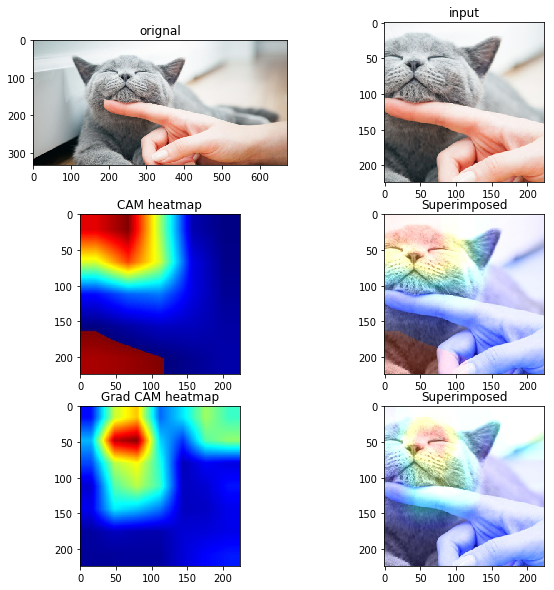

In [10]:
classify_dogcat_and_cam(net=model, url="cats.jpg")

CAM과 Grad CAM은 다소 다른 액티베이션 결과를 보여주나 고양이를 판단하는 기준이 어떻게 되는지 확인하는데는 무리가 없어 보인다. 